# Deep Learning of History of Architecture

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

I will use a pretrained resnet50 to classify photographs of romansque and gothic cathedrals. Since the two architectural styles are historically close to each other, one may expect the classification problem to be not a trivial one. The pictures were downloaded from Google Images using the procedure described in [lesson2-download.ipynb](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb). The present notebook is accompanied by the text files containing the urls of downloaded images. The instruction used for finding the images on Google Images was: "romanesque[gothic] cathedarals exterior view" -gothic[romanesque]. Some of the images ended up being closeups or interior view, though, the proportion of such images is small and hence I refrained from manually filtering the images. Moreover, since I am not an expert in architecture, I can't reliably judge the quality of the dataset in terms of the number of mislabeled examples.

**Downloading images from Google Image**

In [0]:
folder = 'roman'
file = 'urls_roman.csv'

In [0]:
path = Path('data/cathedrals')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [0]:
download_images(Path(file), dest, max_pics=100)

In [0]:
len(get_image_files())

In [0]:
folder = 'gothic'
file = 'urls_gothic.csv'

In [0]:
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [0]:
download_images(Path(file), dest, max_pics=100)

In [0]:
classes = ['roman','gothic']

In [0]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

Initially, I downloaded 100 images for each cathegory. A total of 5 images ended up being corrupted and were removed.

In [16]:
len(get_image_files(path/"roman")), len(get_image_files(path/"gothic"))

(96, 99)

**Viewing data**

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [22]:
data.classes

['gothic', 'roman']

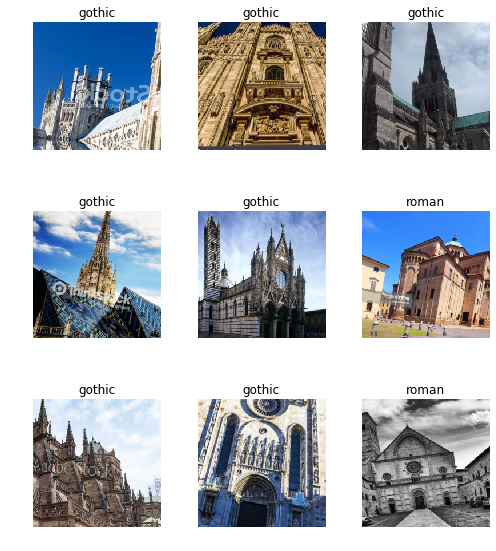

In [23]:
data.show_batch(rows=3, figsize=(7,8))

In [24]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['gothic', 'roman'], 2, 156, 39)

**Training the model**

Use resnet50 architecture with pretrained weights.

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


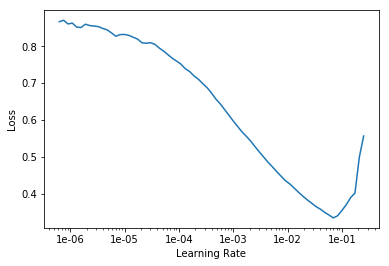

In [28]:
learn.lr_find()
learn.recorder.plot()

From the above plot we see that the default learning rate should be ok.

In [35]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.016376,0.674002,0.461538,00:04
1,0.687279,0.702701,0.358974,00:04
2,0.498675,0.637994,0.230769,00:04
3,0.403518,0.509900,0.205128,00:04


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


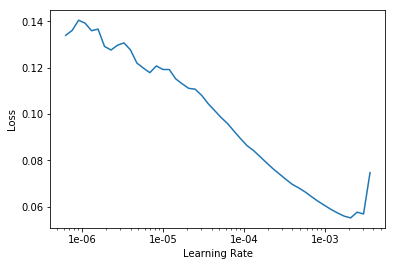

In [38]:
learn.lr_find()
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(15, max_lr=slice(1e-6,2e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.123809,0.444548,0.153846,00:05
1,0.115455,0.411832,0.128205,00:05
2,0.130618,0.376993,0.102564,00:05
3,0.114206,0.359041,0.102564,00:05
4,0.104173,0.351755,0.102564,00:05
5,0.107180,0.326692,0.076923,00:05
6,0.104268,0.308824,0.076923,00:05
7,0.094803,0.305205,0.076923,00:05
8,0.085544,0.298148,0.076923,00:05
9,0.083252,0.290643,0.051282,00:05


We achieve an error rate of **5.1%**, which is amazing given the small size of the training dataset.

In [0]:
learn.save('stage-2')

**Interpretation**

In [0]:
#learn.load('stage-2');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

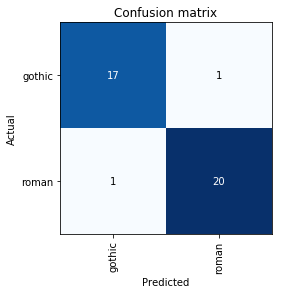

In [42]:
interp.plot_confusion_matrix()

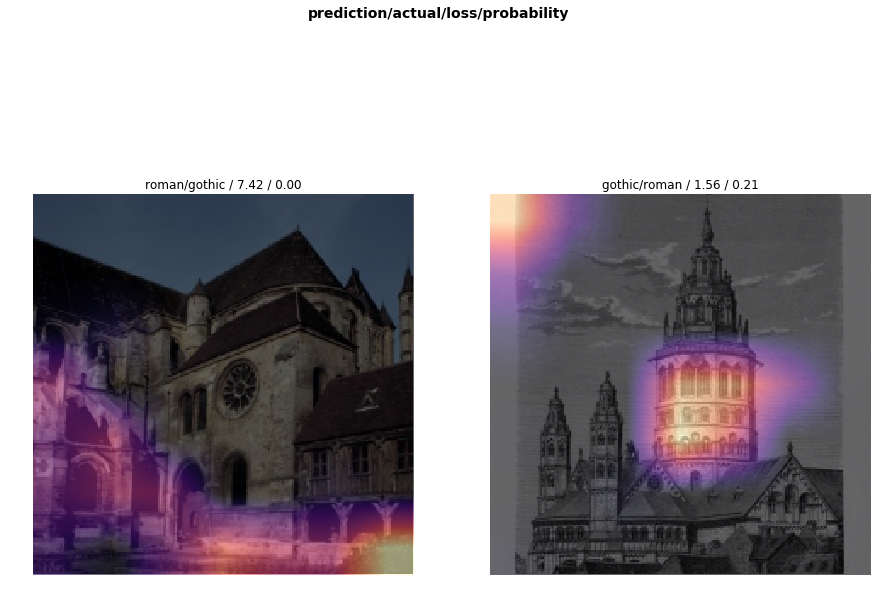

In [43]:
interp.plot_top_losses(2, figsize=(15,11))

As far as I can judge, the picture producing the highest loss is either a mislabeled one or is a picture of an early gothic cathedral exhibiting some characteristics of romansque style, but my judgement might be totally off. 